In [12]:
#Load modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

root_path = "PATH" #FILL your path

In [2]:
#This function is taken out from my KrystalograPy module
def list_files(root_folder,ftype,Silent=True,deep=True):
    """
    Creates list of files of selected format in the directory.
    Parameters:
        FPATH  - absolute path to the folder with diffraction frames files.
        ftype  - Extension of file (e.g. 'tif','h5'...)
        Silent - True by default. If set to False, prints information on number of found frames.
        deep   - True by default - check folder and ALL subfolders. If False will only check in FPATH 
    """
    from pathlib import Path
    if Silent == False:
        print("Reading",ftype,"files...")
    if deep == True:
        Read_folder = Path(root_folder).rglob('*.'+str(ftype))
    elif deep == False:
        Read_folder = Path(root_folder).glob('*.'+str(ftype))
    Files = [x for x in Read_folder]
    if Silent == False:
        print(len(Files),"files found!")
    return Files

In [3]:
CIFs = list_files(root_path,'cif')

keys = ['_chemical_formula_weight ','_cell_measurement_temperature','_cell_formula_units_Z','_cell_volume']
optionals = {'_cell_measurement_temperature':297}

extracted = []
for cif in CIFs[:8000]:
    data = {}.fromkeys(keys)
    with open(cif,'r+') as file:
        for line in file:
            for k in keys:
                if k in line:
                    value = line.split(" ",maxsplit=1)[1].strip().strip("'").split('(')[0]
                    if data[k] == None:
                        data[k] = value
        for o in optionals:
            #Additional if, because some authors like to comment parameters later
            if data[o] == None: 
                data[o] = optionals[o] 
    #This is to prevent us from using incomplete data
    if None not in list(data.values()):
        extracted.append(list(data.values()))

In [4]:
for i,e in enumerate(extracted):
    #All purely numerical values should be changed to float
    if type(e[0]) == str:
        e[0] = e[0].replace(',','.')
    if type(e[1]) == str:
        e[1] = e[1].replace(',','.')
    if type(e[0]) == str:
        e[2] = e[2].replace(',','.')
    if type(e[3]) == str:
        e[3] = e[3].replace(',','.')
    e[0] = float(e[0])
    e[1] = float(e[1])
    e[2] = float(e[2])
    e[3] = float(e[3])

DF = pd.DataFrame(extracted, columns=['weight','temperature','Z','volume'],dtype=float)

def Shuffle_and_split(DataFrame,n=1000,popcol='volume'):
    DataFrame = DataFrame.sample(frac=1).reset_index().drop(columns='index')
    test = DF.iloc[-n:]
    features = DF.iloc[:-n]
    labels = features.pop(popcol)
    features = np.array(features)
    test_labels = test.pop(popcol)
    return(features,labels,test,test_labels)
    
features,labels,test,test_labels = Shuffle_and_split(DF)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers

def volume_model(lr=0.0001):
    model = tf.keras.Sequential([
        layers.Dense(256,activation='relu'),
        layers.Dense(128,),
        layers.Dense(1)
    ])

    model.compile(loss = tf.keras.losses.MeanSquaredError(),
                          optimizer = tf.keras.optimizers.Adam(learning_rate=lr))

    return(model)

model = volume_model()

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=1,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False)

In [8]:
history = model.fit(features,labels,epochs=500,validation_split=0.2,verbose=0,callbacks=[callback])
history_dict = history.history

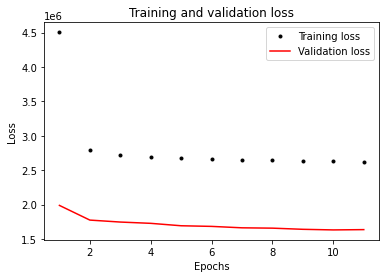

In [9]:
def plot_loss(history_dict):
    
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'ko', markersize=3, label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_loss(history_dict)

32/32 [==============================] - 0s 2ms/step


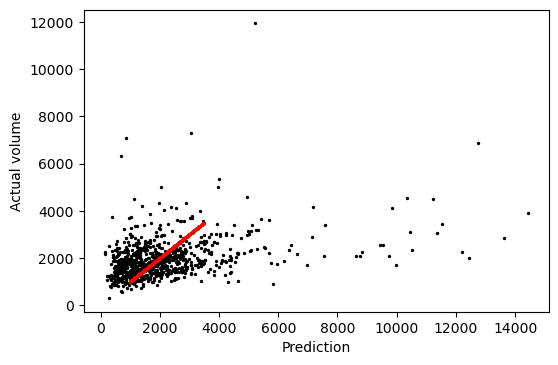

In [10]:
def real_vs_pred(test_data,test_labels,model):
    tested = model.predict(test_data)
    check = []
    for i,v in enumerate(tested):
        check.append([*v,test_labels.iloc[i]])
    check = np.array(check)
    plt.rcParams['figure.dpi'] = 100
    plt.scatter(check[:,1],check[:,0],c='k',s=2)
    plt.scatter(range(1000,3500),range(1000,3500),c='r',s=1)
    plt.xlabel('Prediction')
    plt.ylabel('Actual volume')
    
real_vs_pred(test,test_labels,model)

In [13]:
"""
The parameters which are interesting to us in this task have always the same structure: key: value.
Some of them might require some additional actions later.
"""
#Warning! We want to put column which will be a label to last position
#This will make our life easier at later stage.
#Alternatively, we should move label column at the end of this 
keys = ['_chemical_formula_sum','_cell_formula_units_Z',
        '_cell_measurement_temperature','_cell_volume']
optionals = {'_cell_measurement_temperature':297}

#Because we will be working with atom names, we should make sure that ONLY correct atom names are used.
#To do this, we will check atom names against periodic table.
periodic_table = ['H','D','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar',
                  'K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br',
                  'Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te',
                  'I','Xe','Cs','Ba','La','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi',
                  'Po','At','Rn','Fr','Ra','Ac','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Nh','Fl',
                  'Mc','Lv','Ts','Og','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm',
                  'Yb','Lu','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm','Md','No','Lr']


extracted = []
for cif in CIFs:
    data = {}.fromkeys(keys)
    with open(cif,'r+') as file:
        for i,line in enumerate(file):
            for k in keys:
                if k in line:
                    value = line.split(" ",maxsplit=1)[1].strip().strip("'").split('(')[0]
                    if data[k] == None:
                        data[k] = value
        for o in optionals:
            #Additional if, because some authors like to comment parameters later
            if data[o] == None: 
                data[o] = optionals[o] 
    #This is to prevent us from using incomplete data
    if None not in list(data.values()):
        extracted.append(list(data.values()))

atom_types = []
atd = {}
#Now we want to correctly porcess extracted data
for i,e in enumerate(extracted):
    #All purely numerical values should be changed to float
    e[1] = float(e[1])
    e[2] = float(e[2])
    e[3] = float(e[3])
    #Atom list need additional extraction
    atoms = e[0].split(' ')
    datom = {}
    for a in atoms:
        M = re.match('([A-Za-z]+)(\d*)',a)
        atom = M[1]
        if atom not in atom_types and atom in periodic_table:
            atom_types.append(atom)
        if M[2] == '':
            count = 1
        else:
            count = float(M[2])
        datom[atom] = count
    e[0] = datom
    if all([True for d in e[0] if d in atom_types]) == False:
        extracted.pop(i)
#additional check if all atoms are in periodic table of elements.
#all([True for d in datom if d in atom_types])

atom_types.sort()
    
#Prepare encoding
dt = []
for e in extracted:
    row = []
    for a in atom_types:
        if a in e[0].keys():
            val = e[0][a]
            row.append(val*e[1])
        else:
            row.append(0)
    row.append(e[2])
    row.append(e[3])
    dt.append(row)
    
DF = pd.DataFrame(dt, columns=[*atom_types,'Temp','Cell Volume'])
DF.head()

,Ag,Al,As,Au,B,Ba,Be,Bi,Br,C,...,U,V,W,Xe,Y,Yb,Zn,Zr,Temp,Cell Volume
0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,295.0,404.8
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,297.0,920.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,297.0,298.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,297.0,285.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,297.0,730.3


In [15]:
features,labels,test,test_labels = Shuffle_and_split(DF,popcol='Cell Volume')

In [16]:
model2 = volume_model()
history = model2.fit(features,labels,epochs=500,validation_split=0.2,verbose=0,callbacks=[callback])
history_dict = history.history

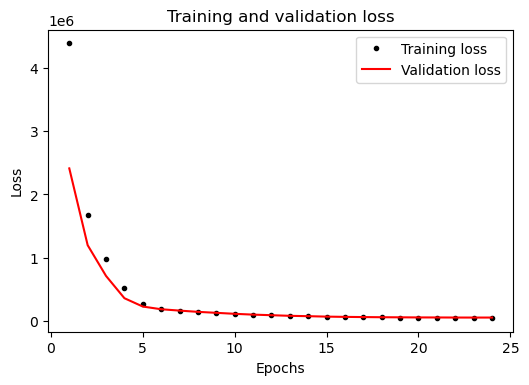

In [17]:
plot_loss(history_dict)

32/32 [==============================] - 0s 2ms/step


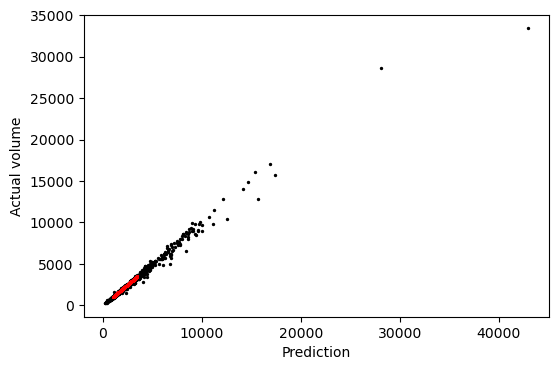

In [19]:
real_vs_pred(test,test_labels,model2)

In [21]:
#Intead of creating sparse one-hot encoding we can translate chemical composition to molecular volume.
#All we need to do is to read table of atom radii
table = pd.read_csv("Atom_table.csv",index_col=0) # !!! You may need to change PATH!!!
table.head()
    
#We don't need other data
WdV_table = table[['Symbol','vdW_Radius']].set_index('Symbol')

def atom_vol(atom_type):
    return(4/3*np.pi*(float(WdV_table.loc[atom_type]))**3) #Volume is in Angstrom^3

dt_2 = []
for e in extracted:
    row = []
    vol = 0
    for a in atom_types:
        if a in e[0].keys():
            val += atom_vol(a)*e[0][a]
    row.append(val*e[1])
    row.append(e[2])
    row.append(e[3])
    dt_2.append(row)
DF2 = pd.DataFrame(data=dt_2,columns=['Mol_V','Temp','Cell Volume'])

In [22]:
features,labels,test,test_labels = Shuffle_and_split(DF2,popcol='Cell Volume')

In [23]:
model3 = volume_model()
history = model3.fit(features,labels,epochs=500,validation_split=0.2,verbose=0,callbacks=[callback])
history_dict = history.history

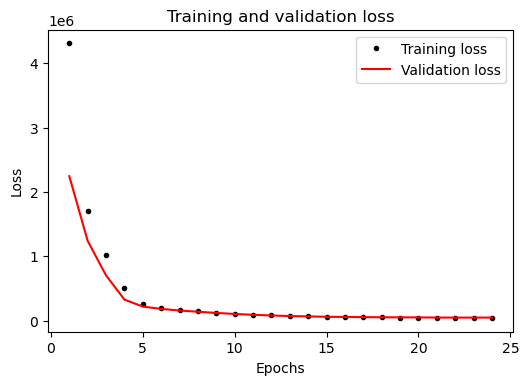

In [24]:
plot_loss(history_dict)

32/32 [==============================] - 0s 2ms/step


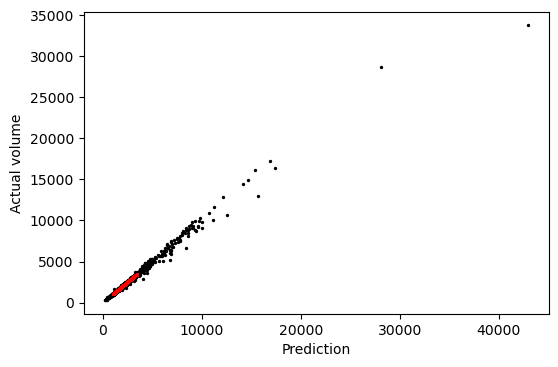

In [25]:
real_vs_pred(test,test_labels,model3)